###Download the dataset

In [0]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2019-07-02 08:30:09--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  7.70MB/s    in 2m 29s  

2019-07-02 08:32:38 (7.39 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



###Unzip the dataset

In [0]:
!tar -xvzf /content/CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

###Spilit the dataset into training and testing folder

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import shutil
from shutil import copyfile

# Change the path to your dataset folder:
base_folder = '/content/CUB_200_2011/'

# These path should be fine
images_txt_path = base_folder+ 'images.txt'
train_test_split_path =  base_folder+ 'train_test_split.txt'
images_path =  base_folder+ 'images/'

# Here declare where you want to place the train/test folders
# You don't need to create them!
test_folder = '/content/CUB_200_2011/test/'
train_folder = '/content/CUB_200_2011/train/'


def ignore_files(dir,files): return [f for f in files if os.path.isfile(os.path.join(dir,f))]

shutil.copytree(images_path,test_folder,ignore=ignore_files)
shutil.copytree(images_path,train_folder,ignore=ignore_files)

with open(images_txt_path) as f:
  images_lines = f.readlines()

with open(train_test_split_path) as f:
  split_lines = f.readlines()

test_images, train_images = 0,0

for image_line,split_line in zip(images_lines,split_lines):

  image_line = (image_line.strip()).split(' ')
  split_line = (split_line.strip()).split(' ')

  image = plt.imread(images_path + image_line[1])

  # Use only RGB images, avoid grayscale
  if len(image.shape) == 3:

    # If test image
    if(int(split_line[1]) is 0):
      copyfile(images_path+image_line[1],test_folder+image_line[1])
      test_images += 1 
    else:
      # If train image
      copyfile(images_path+image_line[1],train_folder+image_line[1])
      train_images += 1 

print(train_images,test_images)
assert train_images == 5990
assert test_images == 5790

print('Dataset succesfully splitted!')

5990 5790
Dataset succesfully splitted!


### Importing packages

In [0]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


###  Training parameters

In [0]:
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '/content/CUB_200_2011/train'
validation_data_dir = '/content/CUB_200_2011/test'
nb_train_samples = 5700
nb_validation_samples = 5500
batch_size = 16
nb_epochs = 50

###  Dataset Preparation

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 5990 images belonging to 200 classes.
Found 5790 images belonging to 200 classes.


###  Load the pretrained Network and Build a classification model on top of Base Network

In [0]:
#import inception with pre-trained weights. do not include fully #connected layers
inception_base = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

# add a global spatial average pooling layer
x = inception_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(200, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)

W0702 08:43:18.590526 140114772113280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 08:43:18.607139 140114772113280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 08:43:18.613138 140114772113280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0702 08:43:18.636397 140114772113280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 08:43:18.637501

###Compile the model

In [0]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

W0702 08:43:33.809455 140114772113280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



###Basic Information

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12793160469346486208
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13110812874811299857
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12328066331868263166
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5309711757604103059
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


###  Training of the model

In [0]:
callbacks = [ModelCheckpoint('imagenet', monitor='val_acc', save_best_only=True)]

history = inception_transfer.fit_generator( train_generator, callbacks = callbacks, samples_per_epoch=nb_train_samples, 
                              nb_epoch=nb_epochs, validation_data=validation_generator, nb_val_samples=nb_validation_samples)

print('Training Completed!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=<keras_pre..., steps_per_epoch=356, epochs=50, validation_steps=5500)`
  after removing the cwd from sys.path.
W0702 08:43:41.888646 140114772113280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wr

Epoch 1/50
356/356 [==============================] - 597s 2s/step - loss: 5.4051 - acc: 0.0079 - val_loss: 5.3181 - val_acc: 0.0126
Epoch 2/50
356/356 [==============================] - 574s 2s/step - loss: 5.1879 - acc: 0.0232 - val_loss: 5.1270 - val_acc: 0.0329
Epoch 3/50
356/356 [==============================] - 571s 2s/step - loss: 4.9854 - acc: 0.0555 - val_loss: 4.8981 - val_acc: 0.0593
Epoch 4/50
356/356 [==============================] - 574s 2s/step - loss: 4.7280 - acc: 0.0986 - val_loss: 4.5961 - val_acc: 0.0926
Epoch 5/50
356/356 [==============================] - 571s 2s/step - loss: 4.4317 - acc: 0.1476 - val_loss: 4.2603 - val_acc: 0.1300
Epoch 6/50
356/356 [==============================] - 571s 2s/step - loss: 4.0826 - acc: 0.2143 - val_loss: 3.8679 - val_acc: 0.1917
Epoch 7/50
356/356 [==============================] - 566s 2s/step - loss: 3.7315 - acc: 0.2722 - val_loss: 3.5154 - val_acc: 0.2438
Epoch 8/50
356/356 [==============================] - 565s 2s/step - 

###List all data in history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


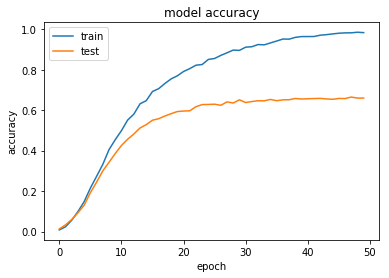

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Summarize history for loss


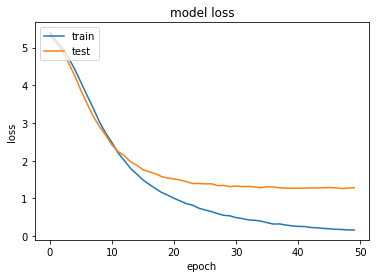

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Save the model into HDF5 file

In [0]:
from keras.models import load_model

inception_transfer.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del inception_transfer  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

###Convert HDF5 file to tflite file

In [0]:
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'my_model.h5' ) # Your model's name
model = converter.convert()
file = open( 'model.tflite' , 'wb' ) 
file.write( model )

W0702 16:54:31.559145 140114772113280 deprecation.py:573] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with distribution=normal is deprecated and will be removed in a future version.
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
W0702 16:54:41.540510 140114772113280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0702 16:54:41.541663 140114772113280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in 

98555312